# Imputation Research Project <img src="https://miro.medium.com/max/1400/1*JPZcoAD9kERfEQxwlaPT-A.jpeg" alt="Alt text image not displaying" width="500" align="right" />
## Notebook 3.0: Autoencoder Model

**Author:** Chike Odenigbo

**Date:** November 25th, 2022

**Notebook Structure:**

* 1.0 Preprocessing

* **1.1 Exploratory Data Analysis**

* 1.2 Masking

* 2.* Models


Water Sugar lutein_zeaxanthin Alcohol

In [2]:
import pandas as pd
import os
from src.visualization.visualize import histogram, box_plot, bar_plot
from pathlib import Path
from notebook_config import ROOT_DIR # setup.py file changed the root of the project so it is set in the config file
ROOT_DIR = ROOT_DIR.as_posix() # convert root path to windows readable path (i.e. change backslash to forward slash)
from joblib import load
import tensorflow as tf
from keras import backend as K
import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [3]:
scaler = load(f'{ROOT_DIR}/models/scaler_water_mar.joblib')

In [2]:
notebook_nm = '3.0-autoencoder'
fig_dir = f'{ROOT_DIR}/reports/figures/'
output_prefix = notebook_nm

In [3]:
pd.set_option('display.max_columns', None)
water_df = pd.read_csv(f'{ROOT_DIR}/data/processed/water.csv')
sugars_df = pd.read_csv(f'{ROOT_DIR}/data/processed/sugars.csv')
lutein_df = pd.read_csv(f'{ROOT_DIR}/data/processed/lutein.csv')
lutein_df

,name,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,lutein_zeaxanthin_mcar,lutein_zeaxanthin_mar,lutein_zeaxanthin
0,"Nuts, pecans",100,72.0,6.2,0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,3.97,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52,17.0,17.0,17.0
1,"Teff, uncooked",100,2.4,0.4,0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,1.84,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82,NaN,NaN,66.0
2,"Sherbet, orange",100,2.0,1.2,1,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,24.32,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10,NaN,NaN,7.0
3,"Cauliflower, raw",100,0.3,0.1,0,30.0,44.3,57.0,0.0,0.507,0.667,0.060,0.050,0.0,0.0,0.0,0.0,0.0,0.00,0.184,48.2,0.0,0.08,0.08,15.5,22.0,0.039,0.42,15.0,0.155,44.0,299.0,0.6,0.27,1.92,0.116,0.086,0.177,0.020,0.257,0.071,0.056,0.000,0.071,0.106,0.217,0.020,0.065,0.071,0.086,0.076,0.020,0.051,0.125,4.97,2.0,1.91,0.97,0.0,0.94,0.0,0.00,0.00,0.28,0.130,0.034,0.031,0.0,0.0,0.76,0.0,0.0,92.07,NaN,NaN,1.0
4,"Taro leaves, raw",100,0.7,0.2,0,3.0,12.8,126.0,0.0,1.513,0.084,0.456,0.209,4825.0,241.0,0.0,2895.0,0.0,0.00,0.146,52.0,0.0,2.02,2.02,108.6,107.0,0.270,2.25,45.0,0.714,60.0,648.0,0.9,0.41,4.98,0.000,0.220,0.000,0.064,0.000,0.000,0.114,0.000,0.260,0.392,0.246,0.079,0.195,0.000,0.000,0.167,0.048,0.178,0.256,6.70,3.7,3.01,0.00,0.0,0.00,0.0,0.00,0.00,0.74,0.151,0.060,0.307,0.0,0.0,1.92,0.0,0.0,85.66,1932.0,1932.0,1932.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100,3.5,1.4,62,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51,0.0,0.0,0.0
7195,"Lamb, cooked, separable lean only, composite o...",100,8.9,3.9,109,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.780,1.758,2.605,0.353,4.294,1.445,0.937,0.000,1.428,2.302,2.613,0.759,1.205,1.241,1.100,1.267,0.346,0.995,1.597,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0

In [95]:
random.seed(30)
param_grid = {
    'prop':[0.1,0.2,0.3],
#     'score_to_probability_func':['sigmoid-right', 'sigmoid-left'],
    'columns':nutrition_df.drop(['name','serving_size'],axis='columns').columns.values
}
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
# params = random.sample(permutations_dicts, 60)
# params

In [96]:
len(permutations_dicts)

216

In [97]:
result_cols = ['column','prop_na','mcar_test_mcar','mnar_test_mnar','mar_test_mar']
df = pd.DataFrame(columns=result_cols)
impute_test_df = [df]
for param in permutations_dicts:
    try:
    #     mechanism = param['mechanism']
        prop = param['prop']
        col = param['columns']
        print(param)
        mcar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MCAR', prop = prop, seed = 20)
        mnar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MNAR', prop = prop, seed = 20)
        mar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MAR', prop = prop, seed = 20)
        mcar_p_val = mt.little_mcar_test(mcar_df)
        mnar_p_val = mt.little_mcar_test(mnar_df)
        mar_p_val = mt.little_mcar_test(mar_df)
    #     print(f'MCAR Test {col} mcar: {mcar_p_val}')
    #     print(f'MCAR Test {col} mnar: {mnar_p_val}')
    #     print(f'MCAR Test {col} mar: {mar_p_val}')
        data = pd.DataFrame([[col,prop, mcar_p_val, mnar_p_val ,mar_p_val]], columns=result_cols)
        # store DataFrame in list
        impute_test_df.append(data)
    except:
        continue
# see pd.concat documentation for more info
impute_test_df = pd.concat(impute_test_df)
impute_test_df

{'prop': 0.1, 'columns': 'total_fat'}
{'prop': 0.1, 'columns': 'saturated_fat'}
{'prop': 0.1, 'columns': 'cholesterol'}
{'prop': 0.1, 'columns': 'sodium'}
{'prop': 0.1, 'columns': 'choline'}
{'prop': 0.1, 'columns': 'folate'}
{'prop': 0.1, 'columns': 'folic_acid'}
{'prop': 0.1, 'columns': 'niacin'}
{'prop': 0.1, 'columns': 'pantothenic_acid'}
{'prop': 0.1, 'columns': 'riboflavin'}
{'prop': 0.1, 'columns': 'thiamin'}
{'prop': 0.1, 'columns': 'vitamin_a'}
{'prop': 0.1, 'columns': 'vitamin_a_rae'}
{'prop': 0.1, 'columns': 'carotene_alpha'}
{'prop': 0.1, 'columns': 'carotene_beta'}
{'prop': 0.1, 'columns': 'cryptoxanthin_beta'}
{'prop': 0.1, 'columns': 'lutein_zeaxanthin'}
{'prop': 0.1, 'columns': 'vitamin_b12'}
{'prop': 0.1, 'columns': 'vitamin_b6'}
{'prop': 0.1, 'columns': 'vitamin_c'}
{'prop': 0.1, 'columns': 'vitamin_d'}
{'prop': 0.1, 'columns': 'vitamin_e'}
{'prop': 0.1, 'columns': 'tocopherol_alpha'}
{'prop': 0.1, 'columns': 'vitamin_k'}
{'prop': 0.1, 'columns': 'calcium'}
{'prop': 0

{'prop': 0.3, 'columns': 'alcohol'}
{'prop': 0.3, 'columns': 'ash'}
{'prop': 0.3, 'columns': 'caffeine'}
{'prop': 0.3, 'columns': 'theobromine'}
{'prop': 0.3, 'columns': 'water'}


,column,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
0,total_fat,0.1,0.0,0.0,0.0
0,saturated_fat,0.1,0.0,1.0,0.0
0,cholesterol,0.1,1.0,1.0,1.0
0,sodium,0.1,1.0,0.0,0.0
0,choline,0.1,0.0,1.0,1.0
...,...,...,...,...,...
0,fatty_acids_total_trans,0.3,1.0,0.0,0.0
0,ash,0.3,1.0,0.0,0.0
0,caffeine,0.3,0.0,1.0,1.0
0,theobromine,0.3,1.0,0.0,0.0


In [98]:
# impute_test_df = pd.concat(impute_test_df)
impute_test_df

,column,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
0,total_fat,0.1,0.0,0.0,0.0
0,saturated_fat,0.1,0.0,1.0,0.0
0,cholesterol,0.1,1.0,1.0,1.0
0,sodium,0.1,1.0,0.0,0.0
0,choline,0.1,0.0,1.0,1.0
...,...,...,...,...,...
0,fatty_acids_total_trans,0.3,1.0,0.0,0.0
0,ash,0.3,1.0,0.0,0.0
0,caffeine,0.3,0.0,1.0,1.0
0,theobromine,0.3,1.0,0.0,0.0


In [99]:
nutrient_impute_test_df = pd.merge(nutrient_stats_df, impute_test_df, left_on='nutrient', right_on='column').drop('column',axis = 'columns')
nutrient_impute_test_df

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
0,galactose,8602,8789,1.922415,0.978723,187,16.214746,0.000000,0.00,1,0.1,0.0,0.0,0.0
1,galactose,8602,8789,1.922415,0.978723,187,16.214746,0.000000,0.00,1,0.2,1.0,1.0,1.0
2,galactose,8602,8789,1.922415,0.978723,187,16.214746,0.000000,0.00,1,0.3,1.0,0.0,1.0
3,theobromine,8545,8789,1.900942,0.972238,244,12.982805,0.000000,0.00,1,0.1,0.0,0.0,1.0
4,theobromine,8545,8789,1.900942,0.972238,244,12.982805,0.000000,0.00,1,0.2,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,water,96,8789,-1.282020,0.010923,0,0.568690,0.000000,63.08,3,0.2,1.0,0.0,0.0
208,water,96,8789,-1.282020,0.010923,0,0.568690,0.000000,63.08,3,0.3,0.0,0.0,1.0
209,saturated_fat,0,8789,-1.318186,0.000000,535,1.640199,18.090795,2.20,3,0.1,0.0,1.0,0.0
210,saturated_fat,0,8789,-1.318186,0.000000,535,1.640199,18.090795,2.20,3,0.2,1.0,0.0,0.0


In [110]:
nutrient_impute_test_df[nutrient_impute_test_df.nutrient == 'water']#.nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
206,water,96,8789,-1.28202,0.010923,0,0.56869,0.0,63.08,3,0.1,1.0,0.0,0.0
207,water,96,8789,-1.28202,0.010923,0,0.56869,0.0,63.08,3,0.2,1.0,0.0,0.0
208,water,96,8789,-1.28202,0.010923,0,0.56869,0.0,63.08,3,0.3,0.0,0.0,1.0


Image found in the "reports/figures" folder saved under 2.1-masking-water-var-sel_mask_variable_selection_tertile_3_zero_value:_water_distribution_water_hist.png


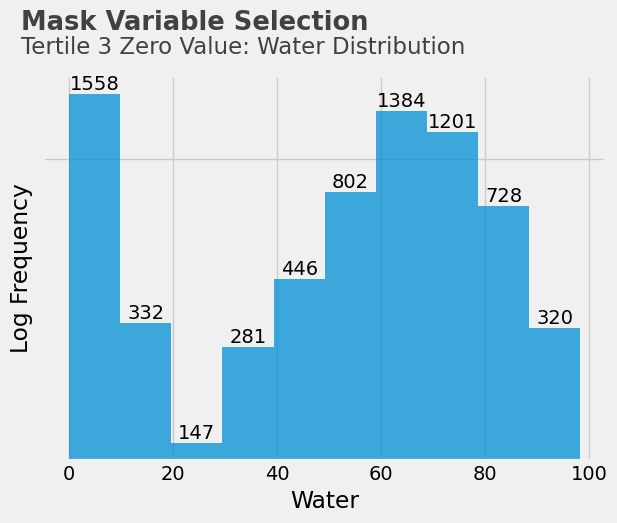

In [111]:
histogram(df = nutrition_df, col = 'water',output_prefix = f'{notebook_nm}-water-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Water Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-sugars-var-sel_mask_variable_selection_tertile_2_zero_value:_sugars_distribution_sugars_hist.png


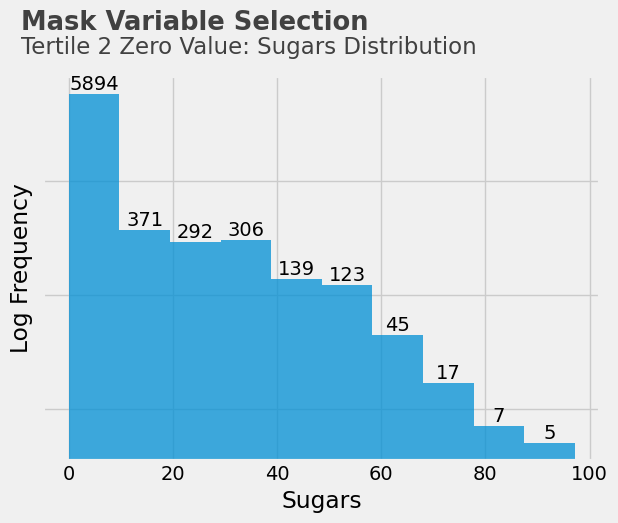

In [113]:
histogram(df = nutrition_df, col = 'sugars',output_prefix = f'{notebook_nm}-sugars-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Sugars Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-vitamin_c-var-sel_mask_variable_selection_tertile_2_zero_value:_vitamin_c_distribution_vitamin_c_hist.png


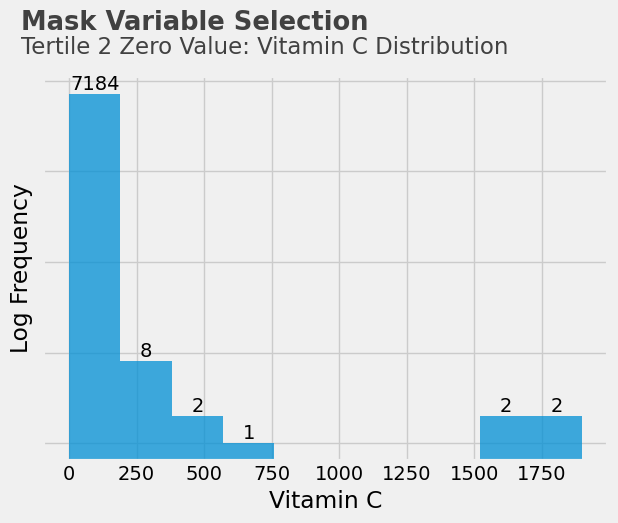

In [112]:
histogram(df = nutrition_df, col = 'vitamin_c',output_prefix = f'{notebook_nm}-vitamin_c-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Vitamin C Distribution', bins = 10, log_scale = True)

In [102]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 1].nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
38,lutein_zeaxanthin,6603,8789,1.169339,0.751280,2186,7.550377,0.0,0.0,1,0.3,1.0,1.0,1.0
37,lutein_zeaxanthin,6603,8789,1.169339,0.751280,2186,7.550377,0.0,0.0,1,0.2,0.0,1.0,1.0
36,lutein_zeaxanthin,6603,8789,1.169339,0.751280,2186,7.550377,0.0,0.0,1,0.1,0.0,1.0,1.0
41,vitamin_d,6469,8789,1.118858,0.736034,1938,8.491550,0.0,0.0,1,0.3,1.0,0.0,0.0
40,vitamin_d,6469,8789,1.118858,0.736034,1938,8.491550,0.0,0.0,1,0.2,0.0,0.0,1.0
39,vitamin_d,6469,8789,1.118858,0.736034,1938,8.491550,0.0,0.0,1,0.1,0.0,0.0,1.0
44,carotene_beta,6359,8789,1.077418,0.723518,1862,7.273375,0.0,0.0,1,0.3,0.0,0.0,0.0
43,carotene_beta,6359,8789,1.077418,0.723518,1862,7.273375,0.0,0.0,1,0.2,0.0,0.0,1.0
42,carotene_beta,6359,8789,1.077418,0.723518,1862,7.273375,0.0,0.0,1,0.1,1.0,0.0,1.0
33,glucose,7453,8789,1.489556,0.847992,1336,5.859980,0.0,0.0,1,0.1,0.0,1.0,1.0


In [106]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 2].nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
45,vitamin_c,4911,8789,0.531918,0.558767,1631,7.853106,0.0,0.000,2,0.1,1.0,0.0,1.0
46,vitamin_c,4911,8789,0.531918,0.558767,1631,7.853106,0.0,0.000,2,0.2,0.0,0.0,1.0
47,vitamin_c,4911,8789,0.531918,0.558767,1631,7.853106,0.0,0.000,2,0.3,0.0,0.0,1.0
66,vitamin_a_rae,4025,8789,0.198138,0.457959,1422,8.365677,0.0,2.000,2,0.1,1.0,0.0,0.0
67,vitamin_a_rae,4025,8789,0.198138,0.457959,1422,8.365677,0.0,2.000,2,0.2,0.0,1.0,1.0
68,vitamin_a_rae,4025,8789,0.198138,0.457959,1422,8.365677,0.0,2.000,2,0.3,0.0,1.0,0.0
132,vitamin_a,2943,8789,-0.209480,0.334850,1390,5.463001,0.0,20.000,2,0.1,1.0,0.0,0.0
133,vitamin_a,2943,8789,-0.209480,0.334850,1390,5.463001,0.0,20.000,2,0.2,1.0,1.0,1.0
134,vitamin_a,2943,8789,-0.209480,0.334850,1390,5.463001,0.0,20.000,2,0.3,0.0,0.0,0.0
48,vitamin_k,4652,8789,0.434346,0.529298,1381,6.683193,0.0,0.000,2,0.1,1.0,1.0,0.0


In [107]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 3].nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
137,manganese,2339,8789,-0.437022,0.266128,1054,12.708819,0.000000,0.022,3,0.1,1.0,1.0,1.0
138,manganese,2339,8789,-0.437022,0.266128,1054,12.708819,0.000000,0.022,3,0.2,0.0,0.0,1.0
139,manganese,2339,8789,-0.437022,0.266128,1054,12.708819,0.000000,0.022,3,0.3,1.0,1.0,1.0
146,folate,1896,8789,-0.603912,0.215724,1016,2.895969,0.000000,9.000,3,0.1,1.0,0.0,1.0
147,folate,1896,8789,-0.603912,0.215724,1016,2.895969,0.000000,9.000,3,0.2,0.0,0.0,1.0
148,folate,1896,8789,-0.603912,0.215724,1016,2.895969,0.000000,9.000,3,0.3,0.0,0.0,1.0
158,magnesium,1000,8789,-0.941459,0.113779,1003,1.730759,0.000000,20.000,3,0.1,0.0,1.0,1.0
159,magnesium,1000,8789,-0.941459,0.113779,1003,1.730759,0.000000,20.000,3,0.2,1.0,1.0,1.0
160,magnesium,1000,8789,-0.941459,0.113779,1003,1.730759,0.000000,20.000,3,0.3,0.0,0.0,1.0
182,calcium,679,8789,-1.062388,0.077256,992,2.725828,0.000000,19.000,3,0.1,1.0,1.0,1.0


In [114]:
nutrition_df['lutein_zeaxanthin'].describe()

count     7199.000000
mean        99.719822
std        847.378557
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      19697.000000
Name: lutein_zeaxanthin, dtype: float64

Image found in the "reports/figures" folder saved under 2.1-masking-magnesium-var-sel_mask_variable_selection_tertile_3_zero_value:_magnesium_distribution_magnesium_hist.png


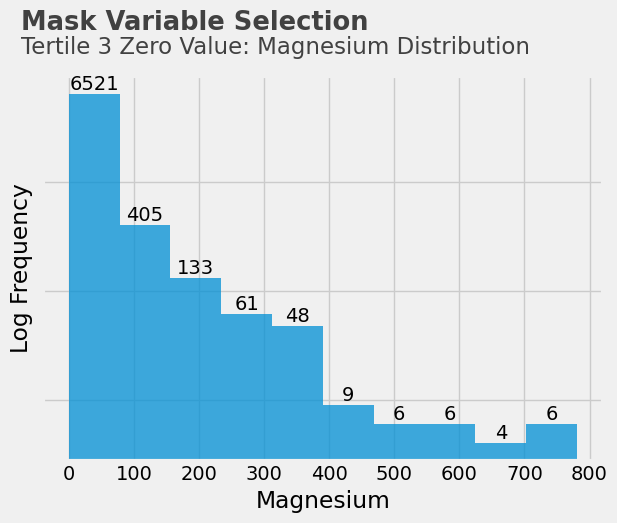

In [109]:
histogram(df = nutrition_df, col = 'magnesium',output_prefix = f'{notebook_nm}-magnesium-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Magnesium Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-vitamin_d-var-sel_mask_variable_selection_tertile_1_zero_value:_vitamin_d_distribution_vitamin_d_hist.png


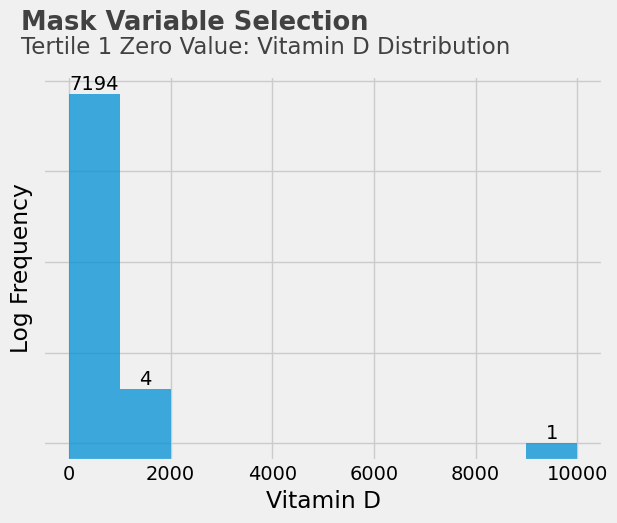

In [105]:
histogram(df = nutrition_df, col = 'vitamin_d',output_prefix = f'{notebook_nm}-vitamin_d-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Vitamin D Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-lutein_zeaxanthin-var-sel_mask_variable_selection_tertile_1_zero_value:_lutein_zeaxanthin_distribution_lutein_zeaxanthin_hist.png


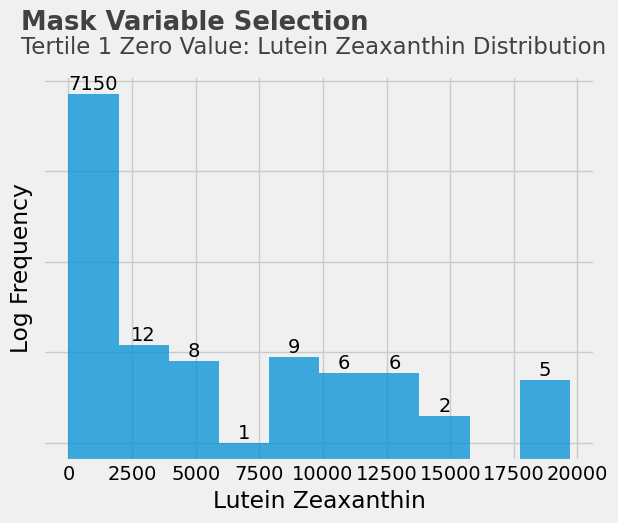

In [103]:
histogram(df = nutrition_df, col = 'lutein_zeaxanthin',output_prefix = f'{notebook_nm}-lutein_zeaxanthin-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Lutein Zeaxanthin Distribution', bins = 10, log_scale = True)

In [118]:
impute_test_df[impute_test_df.column.isin(['water','sugars','lutein_zeaxanthin'])].sort_values('column')

,column,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar
0,lutein_zeaxanthin,0.1,0.0,1.0,1.0
0,lutein_zeaxanthin,0.2,0.0,1.0,1.0
0,lutein_zeaxanthin,0.3,1.0,1.0,1.0
0,sugars,0.1,0.0,0.0,0.0
0,sugars,0.2,1.0,0.0,1.0
0,sugars,0.3,1.0,1.0,0.0
0,water,0.1,1.0,0.0,0.0
0,water,0.2,1.0,0.0,0.0
0,water,0.3,0.0,0.0,1.0


In [161]:
lutein_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'lutein_zeaxanthin', mechanism = 'MCAR', prop = 0.3, seed = 20)
ma = MultivariateAmputation(prop = 0.2, patterns = [{'incomplete_vars':['lutein_zeaxanthin'] ,'mechanism':'MAR', 'score_to_probability_func':'sigmoid-tail'}],verbose = True, seed = 20)
lutein_mar_df = ma.fit_transform(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'))

mt.little_mcar_test(lutein_mar_df)

0.0

In [162]:
water_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'water', mechanism = 'MCAR', prop = 0.2, seed = 20)
water_mar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'water', mechanism = 'MAR', prop = 0.1, seed = 20)
mt.little_mcar_test(water_mar_df)

0.0

In [163]:
sugars_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'sugars', mechanism = 'MCAR', prop = 0.3, seed = 20)
sugars_mar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'sugars', mechanism = 'MAR', prop = 0.1, seed = 20)
mt.little_mcar_test(water_mar_df)

0.0

In [146]:
mt.little_mcar_test(lutein_mar_df)

0.0

In [158]:
full_targets_df = nutrition_df.set_index('name')[['water','sugars','lutein_zeaxanthin']]
lutein_df = nutrition_df.set_index('name').drop('lutein_zeaxanthin', axis = 'columns').join(lutein_mcar_df[['lutein_zeaxanthin']].join(lutein_mar_df[['lutein_zeaxanthin']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['lutein_zeaxanthin'],rsuffix = '_complete'))
lutein_df#.isnull().sum()#[['lutein_zeaxanthin_missing','lutein_zeaxanthin_complete']]

,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,lutein_zeaxanthin_mcar,lutein_zeaxanthin_mar,lutein_zeaxanthin
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Nuts, pecans",100,72.0,6.2,0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,3.97,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52,17.0,17.0,17.0
"Teff, uncooked",100,2.4,0.4,0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,1.84,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82,NaN,NaN,66.0
"Sherbet, orange",100,2.0,1.2,1,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,24.32,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10,NaN,NaN,7.0
"Cauliflower, raw",100,0.3,0.1,0,30.0,44.3,57.0,0.0,0.507,0.667,0.060,0.050,0.0,0.0,0.0,0.0,0.0,0.00,0.184,48.2,0.0,0.08,0.08,15.5,22.0,0.039,0.42,15.0,0.155,44.0,299.0,0.6,0.27,1.92,0.116,0.086,0.177,0.020,0.257,0.071,0.056,0.000,0.071,0.106,0.217,0.020,0.065,0.071,0.086,0.076,0.020,0.051,0.125,4.97,2.0,1.91,0.97,0.0,0.94,0.0,0.00,0.00,0.28,0.130,0.034,0.031,0.0,0.0,0.76,0.0,0.0,92.07,NaN,NaN,1.0
"Taro leaves, raw",100,0.7,0.2,0,3.0,12.8,126.0,0.0,1.513,0.084,0.456,0.209,4825.0,241.0,0.0,2895.0,0.0,0.00,0.146,52.0,0.0,2.02,2.02,108.6,107.0,0.270,2.25,45.0,0.714,60.0,648.0,0.9,0.41,4.98,0.000,0.220,0.000,0.064,0.000,0.000,0.114,0.000,0.260,0.392,0.246,0.079,0.195,0.000,0.000,0.167,0.048,0.178,0.256,6.70,3.7,3.01,0.00,0.0,0.00,0.0,0.00,0.00,0.74,0.151,0.060,0.307,0.0,0.0,1.92,0.0,0.0,85.66,1932.0,1932.0,1932.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Beef, raw, all grades, trimmed to 0"" fat, separable lean and fat, boneless, top round roast, round",100,3.5,1.4,62,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51,0.0,0.0,0.0
"Lamb, cooked, separable lean only, composite of trimmed retail cuts, frozen, imported, New Zealand",100,8.9,3.9,109,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.7

In [167]:
sugars_df = nutrition_df.set_index('name').drop('sugars', axis = 'columns').join(sugars_mcar_df[['sugars']].join(sugars_mar_df[['sugars']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['sugars'],rsuffix = '_complete'))
sugars_df.isnull().sum().nlargest(3)

sugars_mcar     2251
sugars_mar       704
serving_size       0
dtype: int64

In [169]:
water_df = nutrition_df.set_index('name').drop('water', axis = 'columns').join(water_mcar_df[['water']].join(water_mar_df[['water']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['water'],rsuffix = '_complete'))
water_df.isnull().sum().nlargest(3)

water_mcar      1476
water_mar        706
serving_size       0
dtype: int64

In [100]:
nutrient_impute_test_df.to_csv(f'{ROOT_DIR}/data/interim/nutrition_statistics_impute_test_grid_search.csv', index=False)